In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.optimize import minimize_scalar, minimize
from time import time
import sys
sys.path.append('..')

In [2]:
from osd import Problem
from osd.components import AsymmetricNoise, GaussNoise, LaplaceNoise, SmoothSecondDifference, SmoothFirstDifference
from osd.utilities import progress
import cvxpy as cvx

In [3]:
def draw_asymlaplace(mu=0, b=1, k=1, size=1):
    U = np.random.uniform(-k, 1/k, size)
    X = mu - (1 / (b * np.sign(U) * k ** 2)) * np.log(1 - U * np.sign(U) * k ** np.sign(U))
    return X
def draw_laplace(mu=0, b=1, size=1):
    U = np.random.uniform(-0.5, 0.5, size)
    X = mu - b * np.sign(U) * np.log(1 - 2 * np.abs(U))
    return X

In [4]:
np.random.seed(42)
t = np.linspace(0, 1000, 3000)
# signal1 = (np.sin(2 * np.pi * t * 5 / (500.))
#            + np.cos(2 * np.pi * t * 7 / (550.) + np.sin(2 * np.pi * t * 13 / (550.))))
signal1 = np.sin(2 * np.pi * t * 1 / (500.))
y = signal1 + draw_asymlaplace(b=.2, k=5, size=len(signal1))

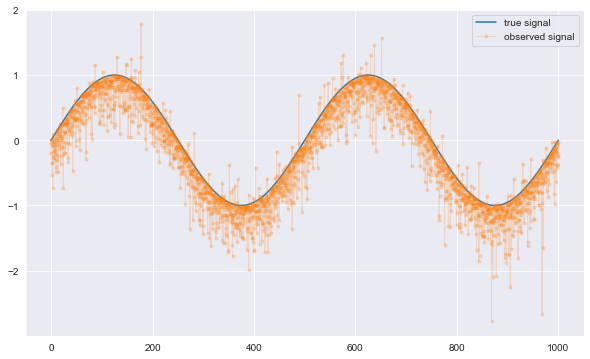

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(t, signal1, label='true signal')
plt.plot(t, y, alpha=0.2, label='observed signal', linewidth=1, marker='.')
plt.legend()
plt.show()

In [6]:
problem = Problem(data=y, components=[GaussNoise, SmoothSecondDifference])
problem.optimize_weights(solver='MOSEK')
gauss_est = problem.estimates[1]

In [7]:
problem = Problem(data=y, components=[AsymmetricNoise(tau=.85), SmoothSecondDifference])
problem.optimize_weights(solver='MOSEK')
asym_est = problem.estimates[1]

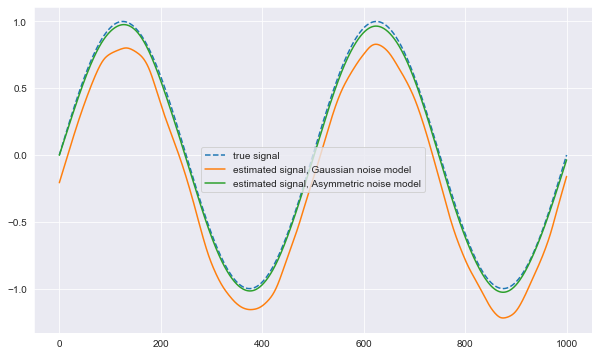

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(t, signal1, label='true signal', ls='--')
plt.plot(t, gauss_est, label='estimated signal, Gaussian noise model')
plt.plot(t, asym_est, label='estimated signal, Asymmetric noise model')
plt.legend()
plt.show()

In [24]:
seed = 948945
weights  = []
residual_costs = []
taus = np.linspace(0.05, 0.95, 51)
total = len(taus)
counter = 0
for ta in taus:
    progress(counter, total)
    problem.parameters[0]['tau'].value = ta
    problem.optimize_weights(solver='MOSEK', seed=seed)
    weights.append(1 / problem.weights.value[1])
    residual_costs.append(problem.holdout_validation(solver='MOSEK', seed=seed))
    counter += 1
progress(counter, total)

In [25]:
best_tau = taus[np.argmin(np.multiply(residual_costs, weights)[:-1])]
best_tau

0.896

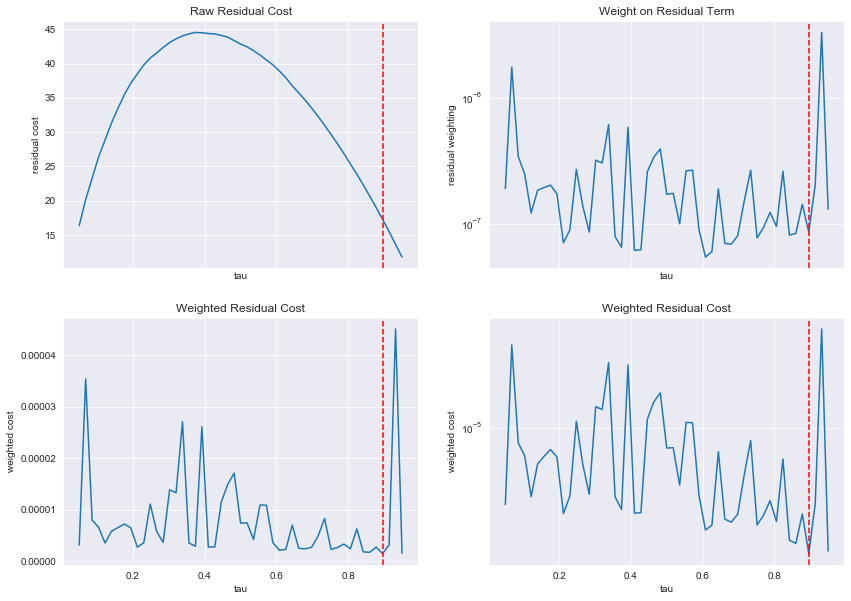

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10), sharex=True)
ax[0, 0].plot(taus, residual_costs)
ax[0, 0].set_xlabel('tau')
ax[0, 0].set_ylabel('residual cost')
ax[0, 0].set_title('Raw Residual Cost')
ax[0, 1].plot(taus, weights)
ax[0, 1].set_xlabel('tau')
ax[0, 1].set_ylabel('residual weighting')
ax[0, 1].set_title('Weight on Residual Term')
ax[0, 1].set_yscale('log')
ax[1, 0].plot(taus, np.multiply(residual_costs, weights))
ax[1, 0].set_xlabel('tau')
ax[1, 0].set_ylabel('weighted cost')
ax[1, 0].set_title('Weighted Residual Cost')
ax[1, 1].plot(taus, np.multiply(residual_costs, weights))
ax[1, 1].set_xlabel('tau')
ax[1, 1].set_ylabel('weighted cost')
ax[1, 1].set_title('Weighted Residual Cost')
ax[1, 1].set_yscale('log')
for i in range(2):
    for j in range(2):
        ax[i, j].axvline(best_tau, ls='--', color='red')
plt.show()

In [27]:
problem = Problem(data=y, components=[AsymmetricNoise(tau=best_tau), SmoothSecondDifference])
problem.optimize_weights(solver='MOSEK')
asym_est = problem.estimates[1]

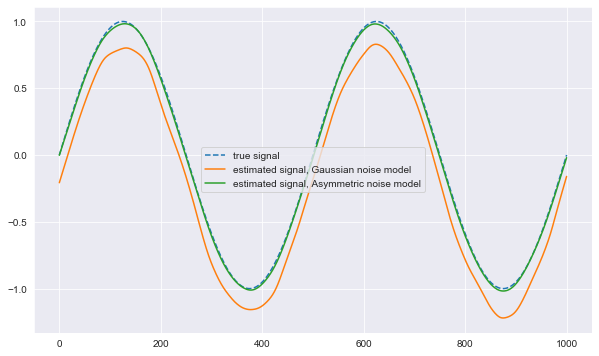

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(t, signal1, label='true signal', ls='--')
plt.plot(t, gauss_est, label='estimated signal, Gaussian noise model')
plt.plot(t, asym_est, label='estimated signal, Asymmetric noise model')
plt.legend()
plt.show()